In [28]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math

# List of visits to be considered
visits = [845346, 849375, 852894, 850590, 836494]
#visits = [849375, 850587]

# Reference visit
ref = 845346

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
ccd = [0, 1, 7, 8, 27, 28, 33, 35]
#ccd = [21, 22, 27, 28]
#ccd = [14]

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_CircularApertureFlux_4_5_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/datadec/cppm/jpreyes/CFHT_Jointcal_2/jointcal_test_2")


In [29]:
for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type="I", doc="CCD number")
        
        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
    
    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

0 2109
1 2588
7 2725
8 2695
27 2567
28 2265
33 2674
35 2308
Ref... 19931


In [30]:
mag = []
oldDist = []
newDist = []
for v in visits :
    if v == ref :
        continue
    for indx, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        oldSrc = butler.get('src', dataid, immediate=True)
        if indx == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type="I", doc="CCD number")
        
            #create the new extented source catalog 
            srcVis = afwTable.SourceCatalog(newSchema)
    
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        srcVis.extend(tmpCat, deep=False)
        
    print "Visit :", v, "nbr of sources :", len(srcVis)
    match = afwTable.matchRaDec(srcRef, srcVis, afwGeom.Angle(1./3600., afwGeom.degrees))
    print "Visit :", v, len(match), "matches found"
    schemaRef = srcRef.getSchema()
    schemaVis = srcVis.getSchema()
    flagKeyRef = []
    flagKeyVis = []
    for f in Flags :
        keyRef = schemaRef[f].asKey()
        flagKeyRef.append(keyRef)
        keyVis = schemaVis[f].asKey()
        flagKeyVis.append(keyVis)
        
    extendKey = schemaRef["base_ClassificationExtendedness_value"].asKey()
    fluxKey = schemaRef["base_CircularApertureFlux_4_5_flux"].asKey()
    fluxSigmaKey = schemaRef["base_CircularApertureFlux_4_5_fluxSigma"].asKey()
    ccdKeyRef = schemaRef["ccd"].asKey()
    ccdKeyVis = schemaVis["ccd"].asKey()
    for m in match :
        mRef = m.first
        mVis = m.second
        
        for f in flagKeyRef :
            if mRef.get(f) :
                continue
        for f in flagKeyVis :
            if mVis.get(f) :
                continue
        
        # cleanup the reference sources in order to keep only decent star-like objects
        if mRef.get(extendKey) >= 0.5 :
            continue
        
        ang = afwGeom.radToMas(m.distance)
        
        # retrieve the CCD corresponding to the reference source
        ccdRef = mRef.get(ccdKeyRef)
        ccdVis = mVis.get(ccdKeyVis)
        
        # retrieve the calibration object associated to the CCDs
        didRef = {'visit':ref, 'filter':filter, 'ccd':ccdRef}
        didRef2 = {'visit':ref, 'filter':filter, 'ccd':ccdRef, 'tract':tract}
        mdRef = butler.get("calexp_md", didRef, immediate=True)
        calib = afwImage.Calib(mdRef)
        # compute magnitude
        flux = mRef.get(fluxKey)
        fluxSigma = mRef.get(fluxSigmaKey)
        if flux /fluxSigma < 5 :
            continue
        if flux > 0. :
            refMag = calib.getMagnitude(flux)
        else :
            continue
        if refMag < 16.5 :
            continue
            
        footprint = mVis.getFootprint()
        if footprint is not None and len(footprint.getPeaks()) > 1 :
            continue
        
        # retrieve the improved wcs and update the coordinate accordingly
        oldWcsRef = afwImage.makeWcs(mdRef)
        oldCoordRef = mRef.getCoord()
        pixelsRef = oldWcsRef.skyToPixel(oldCoordRef.getRa(), oldCoordRef.getDec())
        
        newWcsRefCont = butler.get('wcs', didRef2, immediate=True)
        newWcsRef = newWcsRefCont.getWcs()
        newCoordRef = newWcsRef.pixelToSky(pixelsRef).toIcrs()
        
        didVis = {'visit':v, 'filter':filter, 'ccd':ccdVis}
        didVis2 = {'visit':v, 'filter':filter, 'ccd':ccdVis, 'tract':tract}
        mdVis = butler.get("calexp_md", didVis, immediate=True)
        oldWcsVis = afwImage.makeWcs(mdVis)
        oldCoordVis = mVis.getCoord()
        pixelsVis = oldWcsVis.skyToPixel(oldCoordVis.getRa(), oldCoordVis.getDec())
        newWcsVisCont = butler.get('wcs', didVis2, immediate=True)
        newWcsVis = newWcsVisCont.getWcs()
        newCoordVis = newWcsVis.pixelToSky(pixelsVis).toIcrs()
        
        newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       
                                    
        mag.append(refMag)
        oldDist.append(ang)
        newDist.append(newAngle)
        
        if refMag<20 and newAngle>400 :
            print v, newAngle, refMag, ccdRef, ccdVis, mRef.getCoord(), newCoordVis


Visit : 849375 nbr of sources : 11200
Visit : 849375 9120 matches found
849375 445.824711002 17.8540281118 1 1 IcrsCoord(215.3711748, 53.0042339) IcrsCoord(215.3637380, 53.0016140)
849375 445.824711002 17.5118676555 1 1 IcrsCoord(215.3711748, 53.0042339) IcrsCoord(215.3637380, 53.0016140)
Visit : 852894 nbr of sources : 16547
Visit : 852894 10950 matches found
852894 536.771115694 17.3809319297 35 35 IcrsCoord(214.0813279, 52.4056588) IcrsCoord(214.0815276, 52.4057258)
852894 422.0654225 17.8540281118 1 1 IcrsCoord(215.3711748, 53.0042339) IcrsCoord(215.3637274, 53.0016063)
852894 422.0654225 17.5118676555 1 1 IcrsCoord(215.3711748, 53.0042339) IcrsCoord(215.3637274, 53.0016063)
Visit : 850590 nbr of sources : 20204
Visit : 850590 12572 matches found
850590 572.791751701 19.60467208 7 7 IcrsCoord(214.2238095, 52.9929114) IcrsCoord(214.2241848, 52.9929277)
Visit : 836494 nbr of sources : 12848
Visit : 836494 11232 matches found
836494 490.546022682 17.3809319297 35 35 IcrsCoord(214.0813

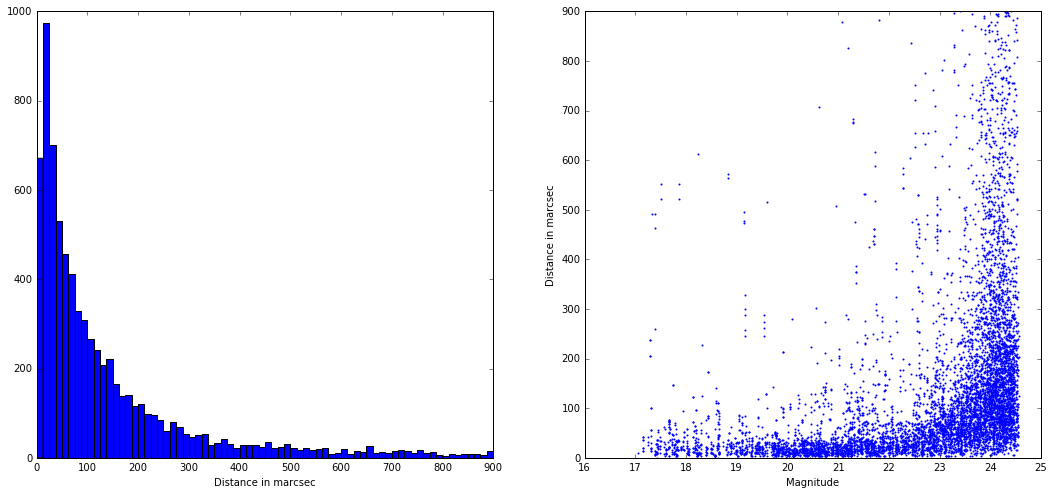

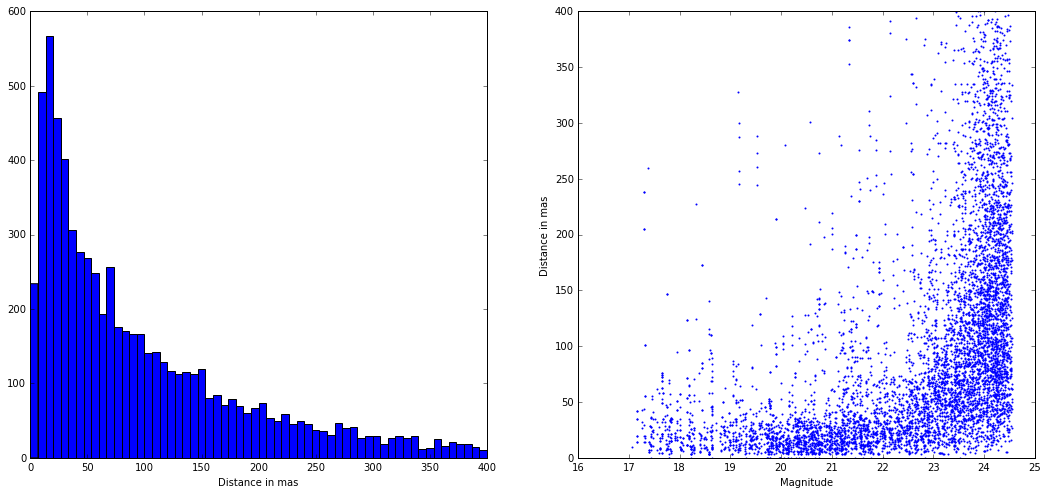

Median value of the astrometric scatter : 76.9010507663 mas


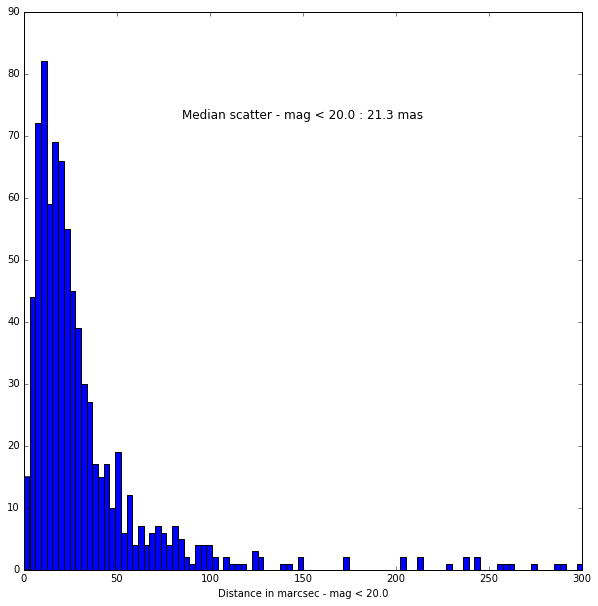

Median scatter - mag < 20.0 : 21.3 mas


In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18,
                                                 8))
ax0.hist(oldDist, bins=80)
ax1.scatter(mag, oldDist, s=1, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(oldDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=200)
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_xlim([0,300])
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))

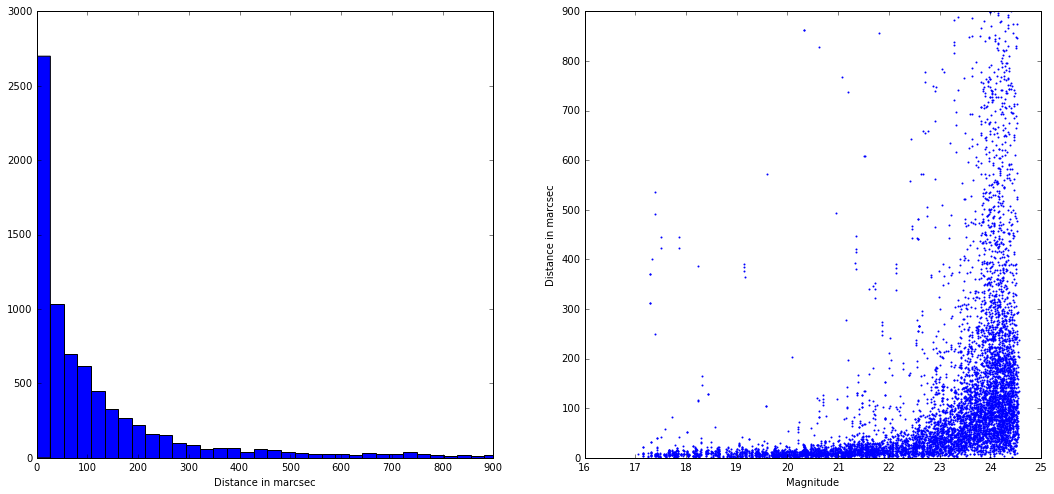

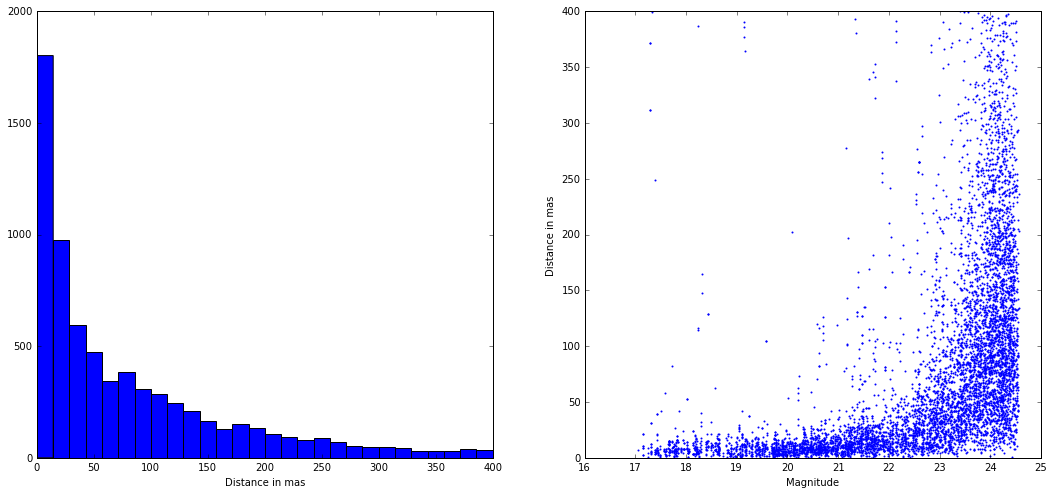

Median value of the astrometric scatter : 55.6006436007 mas


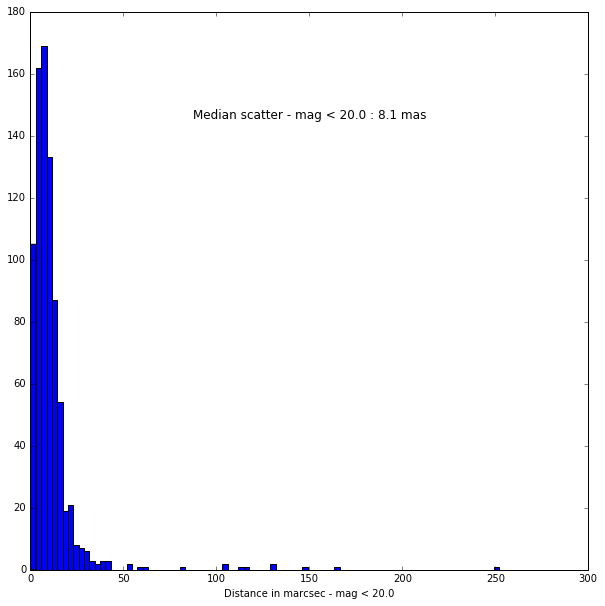

Astrometric scatter (median) - mag < 20.0 : 8.1 mas


In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist, bins=80)
ax1.scatter(mag, newDist, s=1, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(newDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs], bins=200)
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_xlim([0,300])
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))

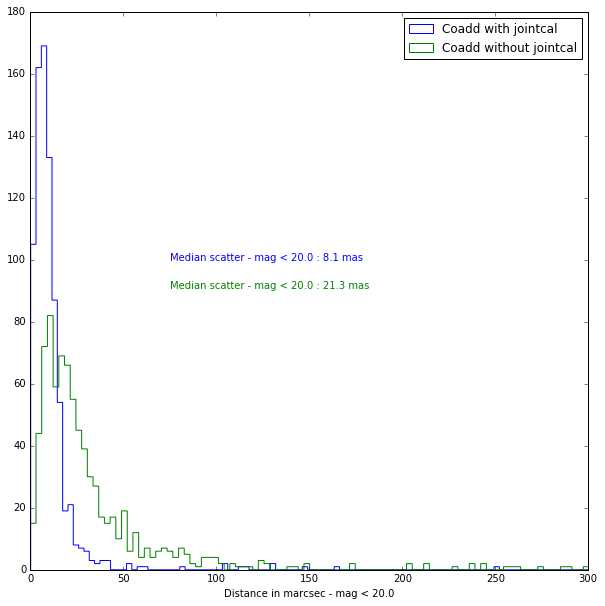

Astrometric scatter (median) - mag < 20.0 : 21.3 mas


In [63]:
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs], bins=200, histtype="step", label="Coadd with jointcal")
ax0.hist(np.asarray(oldDist)[idxs], bins=200, histtype="step", label="Coadd without jointcal")

ax0.legend()
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_xlim([0,300])
#ax0.text("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),(0.4,0.8), xycoords="figure fraction")
ax0.text(0.25, 0.5,"Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])), verticalalignment='bottom', 
        transform=ax0.transAxes, color='green',)
ax0.text(0.25, 0.55,"Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])), verticalalignment='bottom', 
        transform=ax0.transAxes, color='blue',)
plt.show()
ax0.text

#print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))
print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))
